## **Calculating the volume census in T-S coordinates**

### **Description:**

Recipe showing how to calculate the volume census in discrete temperature-salinity coordinates using annual-mean outputs from the National Oceanography Centre Near-Present-Day global eORCA1 configuration of NEMO forced using JRA55-do from 1976-2024.

For more details on this model configuration and the available outputs, users can explore the Near-Present-Day documentation [here](https://noc-msm.github.io/NOC_Near_Present_Day/).

In [8]:
# -- Import required Python packages -- #
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# -- Import nemo_cookbook tools -- #
from nemo_cookbook import compute_volume_census

#### **Optional: Connect Client to Dask Local Cluster to run analysis in parallel.**

**Note:** Although using Dask is not strictly necessary for this simple example using eORCA1, if we wanted to generalise this recipe to eORCA025 or eORCA12 outputs, using Dask would be essential to avoid unnecessary slow calculations using only a single process.

In [ ]:
# -- Initialise Dask Local Cluster -- #
import dask
from dask.distributed import Client, LocalCluster

# Update temporarty directory for Dask workers:
dask.config.set({'temporary_directory': '/home/otooth/work/Diagnostics/proj_NPD_diag/nemo_cookbook/recipes',
                 'local_directory': '/home/otooth/work/Diagnostics/proj_NPD_diag/nemo_cookbook/recipes'
                 })

# Create Local Cluster:
cluster = LocalCluster(n_workers=4, threads_per_worker=5, memory_limit='5GB')
client = Client(cluster)
client

### **Preparing NEMO Model Data**
**Let's begin by loading the grid variables for our eORCA1 NEMO model from the [JASMIN Object Store](https://help.jasmin.ac.uk/docs/short-term-project-storage/using-the-jasmin-object-store/)**. 

**Alternatively, you can replace the ``domain_filepath`` below with a file path to your domain_cfg.nc file and read this with xarray's ``open_dataset()`` function.**

In [2]:
# -- Import eORCA1 domain data -- #
# Define directory path to ancillary files:
domain_filepath = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1/domain"

# Open eORCA1 model grid data:
ds_domain = xr.open_zarr(domain_filepath, consolidated=True, chunks={})

# Extract zonal grid cell widths (m):
e1t = ds_domain['e1t'].squeeze()
# Extract meridional grid cell widths (m):
e2t = ds_domain['e2t'].squeeze()
# Extract Atlantic Ocean mask:
atl_mask = ds_domain['atlmsk'].squeeze()

**Next, we need to import the vertical grid cell thickness, conservative temperature and absolute salinity stored at T-points**

In [3]:
# -- Import eORCA1 tracer data -- #
# Define directory path to model output files:
output_dir = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1/T1y"

# Extract vertical grid cell thicknesses (m):
e3t = xr.open_zarr(f"{output_dir}/e3t", consolidated=True, chunks={})['e3t']
# Extract conservative temperature (C):
thetao_con = xr.open_zarr(f"{output_dir}/thetao_con", consolidated=True, chunks={})['thetao_con']
# Extract absolute salinity (g/kg):
so_abs = xr.open_zarr(f"{output_dir}/so_abs", consolidated=True, chunks={})['so_abs']

### **Calculating Volume Census**

**Now all our input variables are ready, let's calculate the volume census in in T-S coordinates using the ``compute_volume_census()`` function:**

In [ ]:
# Define temperature and salinity bins:
thetao_bins = np.arange(-2, 35, 0.5)
so_bins = np.arange(20, 38, 0.1)
# Apply the Atlantic Ocean sector mask:
vol_ts_atl = compute_volume_census(thetao=thetao_con, so=so_abs,
                                   e1t=e1t, e2t=e2t, e3t=e3t,
                                   thetao_bins=thetao_bins, so_bins=so_bins,
                                   mask=atl_mask
                                   )

# Notice that the output is a dask array, so we haven't actually computed the MOCz yet.
vol_ts_atl

<xarray.DataArray 'ts_volume' (time_counter: 48, thetao_con_bins: 73,
                               so_abs_bins: 179)> Size: 5MB
dask.array<reshape, shape=(48, 73, 179), dtype=float64, chunksize=(48, 73, 179), chunktype=numpy.ndarray>
Coordinates:
  * time_counter     (time_counter) datetime64[ns] 384B 1976-07-02 ... 2023-0...
  * thetao_con_bins  (thetao_con_bins) object 584B (-2.0, -1.5] ... (34.0, 34.5]
  * so_abs_bins      (so_abs_bins) object 1kB (20.0, 20.1] ... (37.8000000000...
Attributes:
    units:          m3
    long_name:      volume of seawater in temperature and salinity coordinates
    standard_name:  ts_volume

**Notice that the output above is a dask array, so we haven't actually computed the volume census yet. To do this, we need to call the ``.compute()`` method:**

In [ ]:
vol_ts_atl = vol_ts_atl.compute()

### **Visualising Volume Census in T-S coordinates**

**Finally, let's visualise the results by plotting the time-mean volume census in T-S space:**

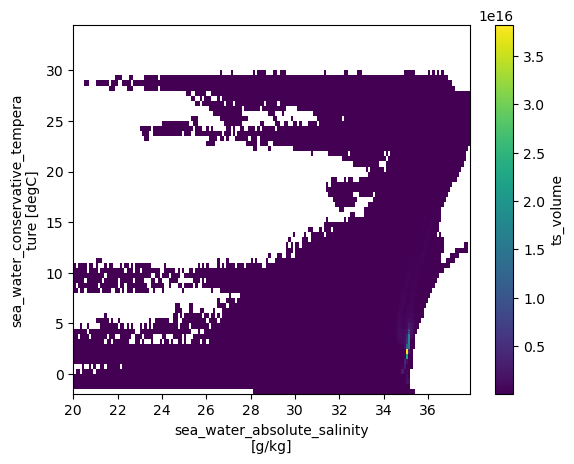

In [ ]:
vol_ts_atl.mean(dim='time_counter').plot()